In [12]:
import torch
import os
import pandas as pd
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# No need to change anything here!
# If there is a GPU available, it will use it,
# otherwise, it will use the CPU

RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
NAME = "classifier_143features_100x100x100_0.001lr_50e_0.5dropout_64bs"
MODEL_PATH = "models/" + NAME + ".pth"

## Dataset Loader

In [15]:
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd

import os


keys = [
 'Revenue Growth',
 'EPS',
 'EPS Diluted',
 'Dividend per Share',
 'Gross Margin',
 'EBITDA Margin',
 'EBIT Margin',
 'Profit Margin',
 'Free Cash Flow margin',
 'Earnings Before Tax Margin',
 'Net Profit Margin',
 'Revenue per Share',
 'Net Income per Share',
 'Operating Cash Flow per Share',
 'Free Cash Flow per Share',
 'Cash per Share',
 'Book Value per Share',
 'Tangible Book Value per Share',
 'Shareholders Equity per Share',
 'Interest Debt per Share',
 'PE ratio',
 'Price to Sales Ratio',
 'POCF ratio',
 'PFCF ratio',
 'PB ratio',
 'PTB ratio',
 'EV to Sales',
 'Enterprise Value over EBITDA',
 'EV to Operating cash flow',
 'EV to Free cash flow',
 'Earnings Yield',
 'Free Cash Flow Yield',
 'Debt to Equity',
 'Debt to Assets',
 'Net Debt to EBITDA',
 'Current ratio',
 'Interest Coverage',
 'Income Quality',
 'Dividend Yield',
 'Payout Ratio',
 'SG&A to Revenue',
 'R&D to Revenue',
 'Intangibles to Total Assets',
 'Capex to Operating Cash Flow',
 'Capex to Revenue',
 'Capex to Depreciation',
 'Stock-based compensation to Revenue',
 'Graham Number',
 'Graham Net-Net',
 'Capex per Share',
 'Gross Profit Growth',
 'EBIT Growth',
 'Operating Income Growth',
 'Net Income Growth',
 'EPS Growth',
 'EPS Diluted Growth',
 'Weighted Average Shares Growth',
 'Weighted Average Shares Diluted Growth',
 'Dividends per Share Growth',
 'Operating Cash Flow growth',
 'Free Cash Flow growth',
 'Receivables growth',
 'Inventory Growth',
 'Asset Growth',
 'Book Value per Share Growth',
 'Debt Growth',
 'R&D Expense Growth',
 'SG&A Expenses Growth',
 'Stock Price',
 'DCF',
]

class StockDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        self.y = df['Label'].to_numpy().astype(int)
        self.features = df.drop(["Company", "Date", "Target", "Label"], axis=1).to_numpy().astype('float32')
#         self.features = df[keys].to_numpy().astype('float32')
#         self.features = df[["Stock Price", "DCF"]].to_numpy().astype('float32')


    def __getitem__(self, index):
        features = self.features[index]
        label = self.y[index]
        
        out_label = 0
        
        if label <= 2:
            out_label = 0
        elif label <= 5:
            out_label = 1
        else:
            out_label = 2
        
        binary_label = 1
        
        if label >= 5:
            binary_label = 2
        
        return features, label

    def __len__(self):
        return self.y.shape[0]

In [16]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

custom_train_transform = transforms.Compose([  
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [17]:
####################################################################
# THIS CELL CAN BE MODIFIED BUT THERE SHOULD NOT BE ANY RANDOMNESS
####################################################################

custom_test_transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [18]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

BATCH_SIZE = 64

In [19]:
train_dataset = StockDataset(csv_path='train_normalized.csv')


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0)


valid_dataset = StockDataset(csv_path='val_normalized.csv')

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0)

test_dataset = StockDataset(csv_path='test_normalized.csv')

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0)

The cell below just checks if the dataset can be loaded correctly.

In [20]:
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        num_features = x.shape[1]
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        print(x.shape)
#         print(y.shape)
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 64
torch.Size([64, 143])
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 64
torch.Size([64, 143])
break minibatch for-loop


In [21]:
# num_features = 143
num_features = 143
classes = 9

If you get an error, make sure the `png-files` folder is unzipped and it the same directory as this notebook!

# Multilayer Perceptron Model

The cell below contains the multi-layer perceptron model. This is the main section where you want to make changes to the architecture.

In [22]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################


class MLP(torch.nn.Module):
    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_hidden_3, num_classes, dropout):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes
        self.dropout = dropout
        
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)        
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_3 = torch.nn.Linear(num_hidden_2, num_hidden_3)

        self.linear_out = torch.nn.Linear(num_hidden_3, num_classes)
        
    def forward(self, x):    
        out = self.linear_1(x)
        out = torch.relu(out)
        out = F.dropout(out, p=self.dropout, training=self.training)

        out = self.linear_2(out)
        out = torch.relu(out)
        out = F.dropout(out, p=self.dropout, training=self.training)

        out = self.linear_3(out)
        out = torch.relu(out)
        out = F.dropout(out, p=self.dropout, training=self.training)
        
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas
        

    
#################################
### Model Initialization
#################################


# the random seed makes sure that the random weight initialization
# in the model is always the same.
# In practice, some weights don't work well, and we may also want
# to try different random seeds. In this homework, this is not
# necessary.
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### IF YOU CHANGED THE ARCHITECTURE ABOVE, MAKE SURE YOU 
### ACCOUNT FOR IT VIA THE PARAMETERS BELOW. I.e., if you
### added a second hidden layer, you may want to add a
### hidden_2 parameter here. Also you may want to play
### with the number of hidden units.

In [23]:
model = MLP(num_features=num_features,
            num_hidden_1=100,
            num_hidden_2=100,
            num_hidden_3=100,
            num_classes=classes,
            dropout=0.5)

model = model.to(DEVICE)

#INCLUDE Kaiming or other weight initialization

In [325]:
def compute_corr_accuracy_and_loss(model, data_loader, device, target_val):
    correct_pred, num_examples = 0, 0
    c2, n2 = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, num_features).to(device)
        targets = targets.to(device)

        logits, probas = model(features.float())
        _, predicted_labels = torch.max(probas, 1)
            
        for p in range(len(targets)):
            if predicted_labels[p].item() == target_val:
                n2 += 1
                if targets[p].item() == predicted_labels[p].item():
                    c2 += 1
                    
            if targets[p].item() == target_val:
                num_examples += 1
                if targets[p].item() == predicted_labels[p].item():
                    correct_pred += 1
                
                
    return 1.0 * correct_pred/num_examples * 100, 1.0 * c2/n2 * 100

def compute_corrlist_accuracy_and_loss(model, data_loader, device, target_list):
    correct_pred, num_examples = 0, 0
    c2, n2 = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, num_features).to(device)
        targets = targets.to(device)

        logits, probas = model(features.float())
        _, predicted_labels = torch.max(probas, 1)
            
        for p in range(len(targets)):
            if predicted_labels[p].item() in target_list:
                n2 += 1
                if targets[p].item() in target_list:
                    c2 += 1
                    
            if targets[p].item() in target_list:
                num_examples += 1
                if predicted_labels[p].item() in target_list:
                    correct_pred += 1
                
                
    return 1.0 * correct_pred/num_examples * 100, 1.0 * c2/n2 * 100

def compute_grouped_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, num_features).to(device)
        targets = targets.to(device)

        logits, probas = model(features.float())
        _, predicted_labels = torch.max(probas, 1)
        
        for i in range(len(targets)):
            num_examples += 1
            c = 0
            if targets[i].item() in [0, 1, 2] and predicted_labels[i] in [0, 1, 2]:
                c = 1
            elif targets[i].item() in [3, 4] and predicted_labels[i] in [3, 4]:
                c = 1  
            elif targets[i].item() in [5, 6, 7, 8] and predicted_labels[i] in [5, 6, 7, 8]:
                c = 1 
            if abs(targets[i].item() - predicted_labels[i]) <= 1:
                c = 1
            correct_pred += c
                
    return 1.0 * correct_pred/num_examples * 100, cross_entropy/num_examples

In [326]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [327]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

NUM_EPOCHS = 50 # Please feel free to change
############################################################

In [328]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, num_features).to(device)
        targets = targets.to(device)

        logits, probas = model(features.float())
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, num_features).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features.float())
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 200:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/050 | Batch 000/978 | Cost: 2.2087
Epoch: 001/050 | Batch 200/978 | Cost: 2.2021
Epoch: 001/050 | Batch 400/978 | Cost: 2.1977
Epoch: 001/050 | Batch 600/978 | Cost: 2.1928
Epoch: 001/050 | Batch 800/978 | Cost: 2.1730
Epoch: 001/050 Train Acc.: 13.65% | Validation Acc.: 12.20%
Time elapsed: 0.06 min
Epoch: 002/050 | Batch 000/978 | Cost: 2.1925
Epoch: 002/050 | Batch 200/978 | Cost: 2.1883
Epoch: 002/050 | Batch 400/978 | Cost: 2.1545
Epoch: 002/050 | Batch 600/978 | Cost: 2.1614
Epoch: 002/050 | Batch 800/978 | Cost: 2.1580
Epoch: 002/050 Train Acc.: 13.96% | Validation Acc.: 13.21%
Time elapsed: 0.11 min
Epoch: 003/050 | Batch 000/978 | Cost: 2.1743
Epoch: 003/050 | Batch 200/978 | Cost: 2.2000
Epoch: 003/050 | Batch 400/978 | Cost: 2.1504
Epoch: 003/050 | Batch 600/978 | Cost: 2.1654
Epoch: 003/050 | Batch 800/978 | Cost: 2.1656
Epoch: 003/050 Train Acc.: 14.88% | Validation Acc.: 14.33%
Time elapsed: 0.16 min
Epoch: 004/050 | Batch 000/978 | Cost: 2.1842
Epoch: 004/050 


#### Evaluation (No Need To Change Any Code in This Section!)

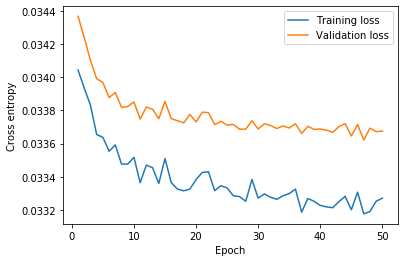

In [331]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

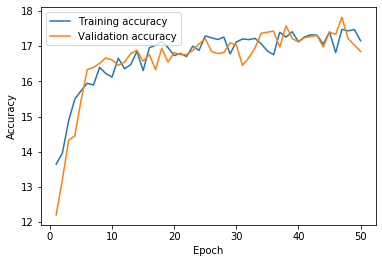

In [332]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [333]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 19.20%


In [334]:
num = 0

model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    for i, (x, y) in enumerate(test_loader):
        if i == num:
            logits, probas = model(x)
            pred = np.argmax(probas, axis=1)
#             for i in range(len(pred)):
#                 print("Pred:", pred[i].item(), ", Target:", y[i].item(), ", Probs: ", probas[i][0].item() + probas[i][1].item() + probas[i][2].item(), "", probas[i][3].item() + probas[i][4].item() + probas[i][5].item(), " ", probas[i][6].item() + probas[i][7].item() + probas[i][8].item())
# #                 print(pred[i].item())
            print(pred)
            print(y)
            print(y[4].item() == np.argmax(probas, axis=1)[4].item())

tensor([8, 6, 6, 6, 1, 6, 1, 1, 1, 1, 0, 0, 0, 0, 8, 7, 6, 7, 6, 6, 6, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 8, 0, 8, 8,
        8, 8, 1, 7, 1, 1, 1, 7, 7, 6, 6, 7, 6, 7, 7, 4])
tensor([2, 5, 5, 6, 0, 5, 0, 0, 1, 1, 1, 2, 0, 2, 1, 1, 5, 2, 1, 3, 1, 2, 0, 0,
        3, 0, 3, 0, 8, 0, 3, 2, 2, 2, 3, 6, 5, 6, 7, 7, 0, 7, 0, 5, 2, 5, 8, 4,
        2, 6, 8, 7, 2, 4, 1, 7, 7, 6, 0, 8, 4, 7, 8, 4])
False


In [335]:
compute_grouped_accuracy_and_loss(model, test_loader, DEVICE)

(46.628785659891044, 0.0)

In [336]:
compute_corr_accuracy_and_loss(model, valid_loader, DEVICE, 8)

(34.50292397660819, 13.563218390804598)

In [337]:
print(compute_corrlist_accuracy_and_loss(model, test_loader, DEVICE, [0, 1, 2]))
print(compute_corrlist_accuracy_and_loss(model, test_loader, DEVICE, [3, 4]))
print(compute_corrlist_accuracy_and_loss(model, test_loader, DEVICE, [5, 6, 7, 8]))

(43.501126972201355, 48.95991882293252)
(30.65806451612903, 33.74041465492758)
(50.221678642409415, 43.0142726201388)


In [32]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [30]:
def convertLabels(label):
    # 0 - 2 : 0
    # 3 - 4: 1
    # 5 - 8: 2
    bounds = [0, 2, 4, 8]
    if label >= bounds[0] and label <= bounds[1]:
        return 0
    elif label <= bounds[2]:
        return 1
    elif label <= bounds[3]:
        return 2
    return -1

In [340]:
# model

In [341]:
loader = test_loader
target_labels = []
pred_labels = []

target_labels_3 = []
pred_labels_3 = []
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    for i, (features, targets) in enumerate(loader):
        logits, probas = model(features)
        pred = np.argmax(probas, axis=1)
#         print("Targets:",targets.shape)
#         print("Predict:",pred.shape)

        for j in range(len(pred)):
            target_labels.append(targets[j].item())
            pred_labels.append(pred[j].item())
            target_labels_3.append(convertLabels(targets[j].item()))
            pred_labels_3.append(convertLabels(pred[j].item()))

In [342]:
# 9 labels
print(f1_score(target_labels, pred_labels, average='micro'))
f1_score(target_labels, pred_labels, average=None)

0.19196297815007907


array([0.38094015, 0.08482299, 0.        , 0.00633914, 0.22460476,
       0.00762527, 0.1699946 , 0.14683691, 0.18265896])

In [343]:
# 3 labels
print(f1_score(target_labels_3, pred_labels_3, average='micro'))
f1_score(target_labels_3, pred_labels_3, average=None)

0.4316091617362779


array([0.46069383, 0.32125473, 0.46339399])

In [344]:
confusion_matrix(target_labels, pred_labels)

array([[1483,  130,    0,    2,  180,    0,  142,  206,  572],
       [ 603,  121,    0,    1,  365,    6,  241,  217,  457],
       [ 444,  114,    0,    2,  514,    7,  259,  221,  368],
       [ 388,   84,    0,    6,  558,    6,  257,  214,  356],
       [ 462,   97,    0,    6,  618,    5,  271,  203,  344],
       [ 297,   81,    0,    3,  585,    7,  261,  231,  333],
       [ 281,  100,    0,    3,  391,    4,  315,  204,  345],
       [ 376,   77,    0,    1,  218,    3,  231,  253,  365],
       [ 737,   38,    0,    0,   68,    0,   86,  173,  474]])

In [346]:
confusion_matrix(target_labels_3, pred_labels_3)

array([[2895, 1064, 2696],
       [1031, 1188, 1656],
       [1987, 1269, 3285]])

In [347]:
l = pred_labels
counts = {}

for i in l:
    if i in counts:
        counts[i] += 1
    else:
        counts[i] = 0

print(counts)

{8: 3613, 6: 2062, 1: 841, 0: 5070, 7: 1921, 4: 3496, 5: 37, 3: 23}


In [348]:
torch.save(model, MODEL_PATH)

In [349]:
## Multiple model inference, Pick average score instead of f1 score

In [33]:
import glob
model_files = glob.glob("models/*.pth")
models = []

In [34]:
for m in model_files:
    models.append(torch.load(m))

In [35]:
model_files

['models/classifier_143features_200x300x100_0.001lr_50e_0.4dropout_64bs_orthogonal.pth',
 'models/classifier_143features_50x75x25_0.001lr_50e_0.3dropout_64bs_xavier_norm.pth',
 'models/classifier_143features_125x250x100_0.001lr_50e_0.2dropout_64bs_xavier.pth',
 'models/classifier_143features_75x100x50_0.001lr_100e_0.3dropout_128bs_sparse_.pth',
 'models/classifier_143features_75x100x50_0.001lr_50e_0.5dropout_256bs_kaiming_norm.pth',
 'models/classifier_143features_150x300x100_0.001lr_100e_0.5dropout_128bs_orthogonal.pth',
 'models/classifier_143features_200x300x200_0.0001lr_50e_0.4dropout_64bs_kaiming_norm.pth',
 'models/classifier_143features_125x250x100_0.001lr_50e_0.2dropout_64bs_xavier_norm.pth',
 'models/classifier_143features_50x75x25_0.001lr_50e_0.5dropout_256bs_kaiming_norm.pth',
 'models/classifier_143features_200x300x200_0.001lr_50e_0.3dropout_64bs_kaiming_norm.pth',
 'models/classifier_143features_75x150x50_0.0001lr_50e_0.5dropout_256bs_kaiming_norm.pth',
 'models/classifier

In [36]:
# loader = test_loader
# target_labels = []
# pred_labels = []

# model = models[]

# target_labels_3 = []
# pred_labels_3 = []
# model.eval()
# with torch.set_grad_enabled(False): # save memory during inference
#     for i, (features, targets) in enumerate(loader):
#         logits, probas = model(features)
#         pred = np.argmax(probas, axis=1)

#         for j in range(len(pred)):
#             target_labels.append(targets[j].item())
#             pred_labels.append(pred[j].item())
#             target_labels_3.append(convertLabels(targets[j].item()))
#             pred_labels_3.append(convertLabels(pred[j].item()))

In [37]:
# print(f1_score(target_labels, pred_labels, average='micro'))
# f1_score(target_labels, pred_labels, average=None)

In [38]:
results = []

for model in models:
    loader = test_loader
    target_labels = []
    pred_labels = []

    target_labels_3 = []
    pred_labels_3 = []
    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        for i, (features, targets) in enumerate(loader):
            logits, probas = model(features)
            pred = np.argmax(probas, axis=1)

            for j in range(len(pred)):
                target_labels.append(targets[j].item())
                pred_labels.append(pred[j].item())
                target_labels_3.append(convertLabels(targets[j].item()))
                pred_labels_3.append(convertLabels(pred[j].item()))
                
    model_results = dict()
    model_results["targets"] = target_labels
    model_results["predictions"] = pred_labels
    model_results["targets_3"] = target_labels_3
    model_results["predictions_3"] = pred_labels_3
    
    model_results["f1"] = f1_score(target_labels, pred_labels, average=None)
    
    results.append(model_results)

/Users/ritik/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
for r in results:
    display(r["f1"])

array([0.39143135, 0.08464849, 0.04349796, 0.03384913, 0.22376346,
       0.11715481, 0.12209106, 0.1545108 , 0.19728624])

array([0.37973375, 0.04983923, 0.01406328, 0.02208353, 0.22829637,
       0.        , 0.11806543, 0.16340004, 0.17990808])

array([0.37842755, 0.10982822, 0.04529915, 0.09958217, 0.18778487,
       0.09405941, 0.11582442, 0.13227045, 0.19480519])

array([0.38869357, 0.11781527, 0.01197007, 0.0834944 , 0.21316614,
       0.02845528, 0.14239897, 0.16079189, 0.19609544])

array([0.38431791, 0.11636149, 0.0030785 , 0.00816327, 0.22120141,
       0.11912641, 0.11544118, 0.15567568, 0.19265191])

array([0.37993379, 0.06855124, 0.0030785 , 0.07834101, 0.20280948,
       0.        , 0.13383459, 0.15609756, 0.18743961])

array([0.37419161, 0.01998097, 0.0010304 , 0.03272727, 0.21823352,
       0.10529846, 0.15679825, 0.15640599, 0.19431676])

array([0.35267569, 0.08562894, 0.03728362, 0.07707432, 0.20500103,
       0.08636545, 0.12981455, 0.13038348, 0.22441243])

array([0.39151321, 0.09538751, 0.01089648, 0.03983326, 0.2344942 ,
       0.05851979, 0.09611184, 0.14770459, 0.21040327])

array([0.37634037, 0.09290954, 0.02643573, 0.11184646, 0.18553331,
       0.04132629, 0.14097969, 0.09023179, 0.17963225])

array([0.38431791, 0.11636149, 0.0030785 , 0.00816327, 0.22120141,
       0.11912641, 0.11544118, 0.15567568, 0.19265191])

array([0.36794855, 0.0928408 , 0.01253616, 0.12996595, 0.18004158,
       0.09087317, 0.06177606, 0.13468208, 0.20469994])

array([0.38059116, 0.05540166, 0.00207039, 0.03253589, 0.2253098 ,
       0.00330033, 0.16812412, 0.14285714, 0.18005739])

array([0.33515964, 0.03023362, 0.        , 0.07207954, 0.19968518,
       0.14922763, 0.16173986, 0.12818096, 0.20597701])

In [40]:
def calculateProb(results, num_labels):
#     probabilities = np.zeros(num_labels * len(results[0]["targets"])).reshape(-1, 9)
    pred = []
    # Iterate row by row over each prediction and calculate aggregated probabilities
    for i in range(len(results[0]["targets"])):
        total = 0
        for j in range(len(results)):
            prediction = results[j]["predictions"][i]
#             probabilities[i][prediction] += results[j]["f1"][prediction]
            total += prediction
        pred.append(total * 1.0 / len(results))
    return pred

In [42]:
test_pred_prob = calculateProb(results, 9)

In [43]:
def calculateFinalPredictions(probabilities):
    pred = []
    prob = []
    prob_diff = []
    for i in range(len(probabilities)):
        if round(probabilities[i]) <= 4:
            pred.append(0)
        else:
            pred.append(1)
    return pred, prob, prob_diff

In [44]:
decisions, prob, diff = calculateFinalPredictions(test_pred_prob)

In [46]:
def convertLabelToBuySell(targets):
    output = []
    
    for i in targets:
        if i <= 4:
            output.append(0)
        else:
            output.append(1)
    return output

In [47]:
actual = convertLabelToBuySell(results[0]["targets"])

In [48]:
f1_score(actual, decisions, average=None)

array([0.63555183, 0.46752685])

In [49]:
confusion_matrix(actual, decisions)

array([[6441, 4089],
       [3298, 3243]])

In [51]:
# Convert to list of dicts to make sorting easier
l = []

for i in range(len(decisions)):
    temp = dict()
    temp["Prediction"] = decisions[i]
    temp["Actual"] = actual[i]
#     temp["Probability"] = prob[i]
#     temp["Diff"] = diff[i]
    l.append(temp)

In [735]:
# t = sorted(l, key=lambda k: k['Diff'], reverse=True) 

In [757]:
counter = 0
correct = 0
total = 0

counter_max = 10

for item in t:
    if item['Prediction'] == 1:
        total += 1
        counter += 1
        if item["Actual"] == 1:
            correct += 1
    if counter >= counter_max:
        break

In [758]:
correct/total

0.5